<h1 style="color:black; font-family:candara; font-size:300%; text-align:center;"> 
    Numerics of vacuum decay in RS
</h1>

***

These are the numerical methods we used to solve the Ordinary Differential Equations (ODEs) describing vacuum decay triggered by black holes within a higher dimensional model of our universe known as the [Randall-Sundrum braneworld model (RS)](https://en.wikipedia.org/wiki/Randall%E2%80%93Sundrum_model). 
In these type of models, 3 of the four fundamental interactions lie on a hypersurface, hence the name *Braneworld* 

For more details, the published article can be found [here](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.99.024046).

For a nicer, simpler and more detailed explanation of some topic one should usually go to a PhD thesis, like [this one](http://inspirehep.net/record/1776158), which happens to be mine.

## Introduction
To understand the parameters and the equations given below, I should explain (at least) a couple of things.
I will just do it quickly and if it interests the reader, I recommend to keep reading about it [here](http://inspirehep.net/record/1776158).

The **metric** of a Randall-Sundrum (RS) spacetime can be given in [horospherical coordinates](https://arxiv.org/abs/hep-th/0011156) by  
$$  ds^2 =  e^{-2|z|/\ell} g_{\mu\nu} dx^\mu dx^\nu + dz^2, $$

where the curvature radius $\ell$ is related to the (negative) cosmological constant $\Lambda_5$ by
$$   \Lambda_{5} = - \frac{6}{\ell^{2}}.$$

Finally, we should mention that the tensor $g_{\mu\nu}$ is $diag(f,1/f,1,1)$ and for RS $f=1$. 
However, we will be interested in more general functions. 

In higher dimensional models like this one, the higher dimensional newton's constant $G_5$ is related to the usual 4D gravitational constant by $G_5 = G \ell$. One can also see that the gravitational constant in $n$ arbitrary dimensions $G_n$ and the [Planck's mass](https://en.wikipedia.org/wiki/Planck_mass) $M_n$ is given by $[G_{n}] = [M_{n}]^{2-n}$. 

Now, since this model allows the brane (our accessible universe) to have its own cosmological constant $\sigma$ and since we know that our universe is expanding (and hence has a positive cosmological constant), one can imagine that both of these cosmological constants have a sort of _fight_ amongst them. We can fine tune this tension by imagining our cosmological constant is given by 
$$ \sigma = {6 \over 8 \pi G_{5} \ell}.$$

This turns off the _effective cosmological constant_ $\Lambda_4$.

## Equations
As promised, I will not go into details of how we obtained the following equations that describe a scalar field around a black hole to _decay_, that is, to suddenly change from a minimum of energy to an even lower one by a mechanism known as quantum tunneling. 
Here it should be enough to state what the components are.

We begin by writing the lagrangian of a scalar field described by the usual matter lagrangian in its Euclidean form
$$  {L}_{m} = {1\over 2} g^{\mu\nu}\,\partial_{\mu}\phi\, \partial_{\nu}\phi + V(\phi),$$

here the scalar field is denoted by $\phi$, the inverse of the metric tensor is $g^{\mu\nu}$ (given by the metric of the spacetime considered) and the potential $V(\phi)$ is a function of the scalar field only.
Due to the symmetry of the problem, the scalar field $\phi$ is a function of the radial distance on the brane $r$.

With a metric function 
$$ f(r) =   1 - {2 G \mu(r) \over r} - {r_{Q} ^{2} \over r^{2}},$$

where $\mu(r)$ is a "mass" function that dependes only on $r$, the tidal parameter is $r_Q^2$.

After looking at the Einstein Equations, we see that the only relevant equations describing our problem are 
$$ f\phi''+f'\phi'+\frac2r f\phi'+f\delta'\phi'-\partial_{\phi}V = 0,\\
\mu'=4\pi r^2\left\{ \frac12 f\phi'{}^2+V-
\frac{2\pi G}{3}\ell^2(\frac12 f\phi'{}^2-V)
(\frac32 f\phi'{}^2+V)\right\}\\
\delta'=4\pi G r\phi'{}^2\left\{1-\frac{4\pi G}{3}\ell^2
(\frac12 f\phi'{}^2-V)\right\}.$$

This means that our problem is reduced to 3 ODEs of second order.

**This** is the system of equations we want to solve numerically to find a stable solution.  

In [1]:
# We begin with some standard imports and parameters:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#======================Parameters===========================
g =  1.0e-5   #potential parameter (1.0e-6)
dr = 1.0e-3   #step (1.0e-2)
Mp = 1.0      #4D Planck mass can be taken to be 1.0
M5 = 1.0e-3   #5D Planck mass (1.0e-3)
Lambda = 1.0e-6  #V(Lambda)=0  (1.0e-6)
lads = Mp**2/M5**3 #np.log(Lambda/Mp)        #AdS radius (ell)
G = 1.0/(8.0*np.pi*Mp*Mp)    # Newtons gravitational constant in 4D
tidal = 1.0 # b=3*pi*tidal/4 (1.0) # shorthand to not write a lot 
b = 3*np.pi/4 #This parameter is expected to be of order 1 as can be seen from our paper
rotation = 0.0	# a/r0 parameter
drmax = 5.0e5  	#maximum allowed step length (1.0e5)
tinitial = 2.0e4	#black hole radius (100.0)
rinfinite =5.0e7 	#maximum allowed radius (1.0e10)
stopcond =1.0e-4	#stops when phi(r)<phi(0)*stopcond (1.0e-4)

In [12]:
#=========================Class=============================

class ODE:
    """A class to compute the evolution of a system described by a set 
    of differential equations using the Euler method. Contains variables which store
    the current values of the fields as well as a history."""
    
    def __init__(self, x0=np.array([], dtype='float64'), t0=tinitial, dt=tinitial*.01, method='RK'):
        """ Set the variables used by the class:
        :vector x0: array with initial value of [t,phi,phiprime,mu,delta] in that order   
        :param dt : integration radius step
        :param t0 : initial 'time' (independent variable)
        :method   : decides whether to use 'Euler' or 'RK' (Runge-Kutta 4)
        """
        self.reset(x0, t0, dt);

    def reset(self, x0, t0=tinitial, dt=0.001, method='RK'):
        """ Reset the integration parameters : 
        :vector x0: array with initial value of [t,phi,phiprime,mu,delta]
        :param dt : radial step
        :param t0 : initial radius
        """
        self.x = np.array(x0, dtype='float64') # ensure we use floats!
        self.t = t0
        self.dt = dt
        self.t_list = []
        self.x_list = []
        self.method = method

    def F(self, t, x):
        """ Return the right hand side of the equation dx/dt = F(t,x)
        :param t  : current time
        :param x0=[t,phi,phiprime,mu,delta] : current function values.
        In this function we actually determine the equation to be
        solved (Tidal BH), with the initial conditions we give to the object.
        """        
        #--------------------------------------------------
        #Defining the variables
        t0=tinitial
        phi = self.x[0]       # field phi
        phiprime = self.x[1]  # dphi/dt
        mu = self.x[2]        # mass parameter
        delta = self.x[3]     # parameter coming from the metric
        
        #--------------------------------------------------
        #Writing down the diff. equations
        
        c=1.0-b*t0/lads
        f=(1.0-(t0/t))*(1.0+c*(t0/t))-2.0*G*mu/t # metric function
        energy=self.V(phi)-0.5*f*pow(phiprime,2)
        
        # To know what should be the value of phi near the BH, we Taylor expand.
        # ddphit0 is the value of the second derivative of the field phi evaluated at t=t0
        ddphit0=self.dV(phi)*(t0*t0*self.ddV(phi)+2.0)/16.0 
        
        #Define 'extra' pieces wrt usual 4 dimensional Einstein Gravity
        muprimeextra=(2*np.pi/3.0)*G*pow(lads,2)*energy*(1.5*f*pow(phiprime,2)+self.V(phi))
        deltaprimeextra=2.0*(2*np.pi/3)*G*pow(lads,2)*energy
        
        #Actual equations for mu and delta
        muprime = 4.0*np.pi*t*t*(0.5*f*phiprime*phiprime+self.V(phi) + muprimeextra)
        deltaprime = 4.0*np.pi*G*t*phiprime*phiprime*(1.0 + deltaprimeextra)
        
        df=-2.0*G*muprime/t+2.0*G*mu/pow(t,2)+(t0/pow(t,2))*(1.0-c+2.0*c*t0/t)
        
        #dx0 = 1.0
        dx0 = phiprime
        dx2 = muprime
        dx3 = deltaprime
        if f>1.0*10e-7:
            dx1 = (self.dV(phi)-df*phiprime)/f-(2.0/t +deltaprime)*phiprime
        else:
            dx1 = ddphit0
        
        
        return(np.array([dx0,dx1,dx2,dx3]))
    
    def V(self,phi):
        ln=np.log(np.sqrt(8*np.pi)*np.sqrt(G)*abs(phi))
        l=np.log(Lambda/Mp)
        return(.25*g*(pow(ln,4)-pow(l,4) )*pow(phi,4) )

    def dV(self,phi):
        ln=np.log(np.sqrt(8*np.pi)*np.sqrt(G)*abs(phi))
        l=np.log(Lambda/Mp)
        return( g*(pow(ln,4)+pow(ln,3)-pow(l,4)) * pow(phi,3) )

    def ddV(self,phi):
        ln=np.log(np.sqrt(8*np.pi)*np.sqrt(G)*abs(phi))
        l=np.log(Lambda/Mp)
        return( 3.0*g*(pow(ln,4) + (7./3.0)*pow(ln,3) + pow(ln,2) - pow(l,4))*pow(phi,2) )
    
    def _one_step_Euler(self): #One step with Euler method
        """ Performs a single integration step using the Euler method.
        """
        self.x += self.dt*self.F(self.t, self.x)
        self.t += self.dt
       
    def _one_step_RK(self): #One step with Runge-Kutta
        """ Performs a single integration step using the RK4 method.
        """
        k1 = self.F(self.t, self.x)
        K = self.x + 0.5*self.dt*k1

        k2 = self.F(self.t+0.5*self.dt, K)
        K = self.x + 0.5*self.dt*k2

        k3 = self.F(self.t+0.5*self.dt, K)
        K = self.x + self.dt*k3

        k4 = self.F(self.t+self.dt, K)
        # self.v -> v(r+dt)
        self.x += self.dt / 6.0*( k1 + 2.0*(k2+k3) + k4)
        # r -> r + dt
        self.t += self.dt
    
    #This has to be defined by the user (in principle)
    def iterate(self, tmax, fig_dt=-1):
        """ Solve the system of equations dN/dt = F(N)  until tinitial
            Save N and r in lists N_list and t_list every fig_dt
        :param rmax   : integration upper bound
        :param fig_dt : interval between data point for figures (use dt if < 0)
        """
       
        if(fig_dt < 0) : fig_dt = self.dt*0.99 # if negative (if the user didn't input something) it will take all the steps produced in the iterations
        
        next_fig_t = self.t*(1-1e-20) # ensure we save the initial values
        
        tmax -= self.dt*0.1   # stop as close to rmax as possible
        while (self.t < tmax): # integrate until rmax
            if self.method == 'RK':
                self._one_step_RK()#in this line we decid what numerical method to use (Right now is RK)
            else:
                self._one_step_Euler()
            if(self.t >= next_fig_t): # save fig when next_fig_t is reached       
                self.x_list.append(np.array(self.x)) # force a copy of x!
                self.t_list.append(self.t)
                next_fig_t += fig_dt # set the time to show next in the figure 

    def plot(self, i, j=0, style="k-"):
        """ plot x[i] versus t    (i > 1 and j = 0)  using style
            plot x[i] versus x[j] (i > 1 and j > 1)  using style
            plot r    versus x[j] (i = 0 and j > 1)  using style
        
          :param i    : index of function for y-axis 
          :param j    : index of function for x-axis
          :param style: style string for the plot function
        """
        # Just to make it a bit friendlier
        options={'t':0,'phi':1,'phiprime':2,'phip':2,'mu':3,'dmu':3,'delta':4}
        if type(i)==str:
            i=options[i]
        if type(j)==str:
            j=options[j]

        # Choices to plot
        if(j==0):
            lx = np.array(self.t_list)/tinitial
            plt.xlabel(r'$t/t0$')
        else: # extra item i-1 from each element of f_list
            lx = list(map (lambda v : v[j-1] , self.x_list))
        if(i==0):
            ly = self.t_list
        elif i==1: # extra item i-1 from each element of f_list
            ly = list(map (lambda v : v[i-1]/Lambda , self.x_list))
            plt.ylabel(r'$ \phi / \Lambda$')
        elif i==3: # extra item i-1 from each element of f_list
            muhorizonte=(b*tinitial*tinitial)/(2*G*lads)
            ly = list(map (lambda v : (v[i-1]-muhorizonte)/Lambda , self.x_list))
            plt.ylabel(r'$\Delta \mu / \Lambda$')
        else:
            ly = list(map (lambda v : v[i-1] , self.x_list))
        plt.plot(lx, ly, style);

In [15]:
# Do the iterations in the equations with the initial values (that I already knew were right from the shooting algorithm in Mathematica)
phi_ini=3.2922e-6
phiprime_ini= (-1)*4.78596e-10
mh=(b*tinitial*tinitial)/(2*G*lads)
d_ini=0.0

A = ODE([phi_ini, phiprime_ini, mh, d_ini], 20000, tinitial*.01)
A.iterate(tmax=rinfinite, fig_dt=.1)

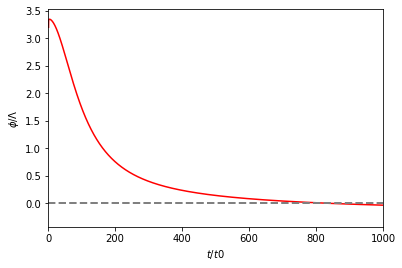

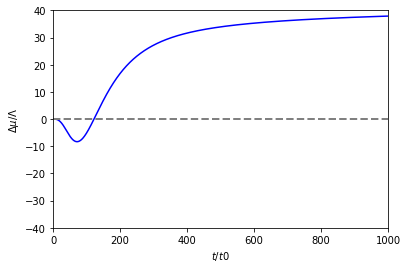

In [14]:
#Plot the field phi vs the radius
A.plot('phi',style='r-') # Here we have not written the x variable cause it's automatically assigned to be t
plt.xlim(0,1000)
plt.plot([0, 1000], [0, 0], color='gray', linestyle='--', linewidth=2)
plt.show()

#Plot mu vs the radius
A.plot('mu','t','b-')
plt.ylim([-40,40])
plt.xlim(0,1000)
plt.plot([0, 1000], [0, 0], color='gray', linestyle='--', linewidth=2)
plt.show()

These solutions are the first that are stable and the initial values were obtained by a shooting method in Mathematica.
From these images we can see that the scalar field $\phi$ changes smoothly relatively close to 0 and then drops down to a minimum (0).

It is remarkable that such a complicated differential equation has an easy interpretation!